In [ ]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
from torchvision.utils import make_grid
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as tt
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import pandas as pd
import torch.optim as optim

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
class Resnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)

        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def forward(self, xb):
      return self.network(xb)
    
#     def freeze(self):
#         # To freeze the residual layers
#         for param in self.network.parameters():
#             param.require_grad = False
#         for param in self.network.fc.parameters():
#             param.require_grad = True
    
#     def unfreeze(self):
#         # Unfreeze all layers
#         for param in self.network.parameters():
#             param.require_grad = True
model_res = Resnet18()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_res

Resnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 33.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=82b8c9015944b7e4261aa45c65fc569c89927c08cceefa6414d6805c116c767a
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM,EigenCAM
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

(224, 224, 3)


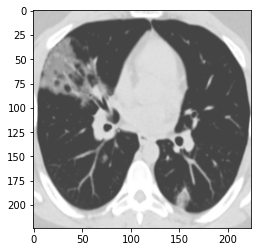

In [ ]:
image=io.imread("Covid (22).png")

image_gray=image.reshape(224,224,1)
image=np.concatenate([image_gray, image_gray, image_gray], axis=2)
image=image.astype("float32")
image=image/image.max()
print(image.shape)
plt.imshow(image, cmap='gray')

In [ ]:
image_input=torch.tensor(image).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

torch.Size([1, 3, 224, 224])

In [ ]:
image_input.dtype

torch.float32

In [ ]:
image_input = image_input.to(device='cpu')
print(image_input.device)

cpu


In [ ]:
model_res(image_input)

tensor([[0.3911, 0.3055]], grad_fn=<AddmmBackward0>)

In [ ]:
target_layers = [model_res.network.layer4[-1]]

In [ ]:
cam = GradCAM(model=model_res, target_layers=target_layers, use_cuda=False)

In [ ]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):        
        print(model_output.shape)
        return model_output[self.category]

In [ ]:
targets = [ClassifierOutputTarget(category=1)]

In [ ]:
image_input.shape

torch.Size([1, 3, 224, 224])

In [ ]:
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam.shape

torch.Size([2])


(1, 224, 224)

In [ ]:
grayscale_cam=grayscale_cam[0]
grayscale_cam.shape

(224, 224)

In [ ]:
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)

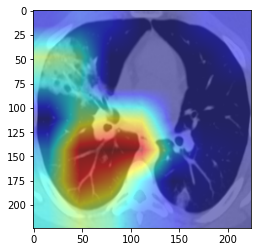

In [ ]:
plt.imshow(cam_image)

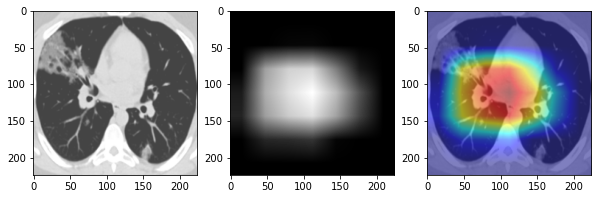

In [ ]:
cam = EigenCAM(model=model_res, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

In [ ]:
class CovidClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)
model = CovidClassification()

In [ ]:
model

CovidClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_

In [ ]:
I1=io.imread("Covid (22).png")
I1=skimage.util.img_as_float32(I1)
I1 = resize(I1, (32,32,3),anti_aliasing=True)
#I1 = I1.reshape(1,I1.shape[0],I1.shape[1])

In [ ]:
I=io.imread("Covid (22).png")
I=skimage.util.img_as_float32(I)
I = resize(I, (32,32,1),anti_aliasing=True)
I = I.reshape(I.shape[0],I.shape[1])
I = torch.tensor(I, dtype=torch.float32)
I = I.expand(1,3, I.shape[0],I.shape[1])
input_tensor = I

In [ ]:
target_layers = [model.network[10]]
e_cam = EigenCAM(model=model, target_layers=target_layers)
g_cam = GradCAM(model=model, target_layers=target_layers)

e_grayscale_cam = e_cam(input_tensor=input_tensor,targets = targets)
g_grayscale_cam = g_cam(input_tensor=input_tensor,targets = targets)

e_grayscale_cam = e_grayscale_cam[0, :]
g_grayscale_cam = g_grayscale_cam[0, :]

e_visualization = show_cam_on_image(I1, e_grayscale_cam, use_rgb=True)
g_visualization = show_cam_on_image(I1, g_grayscale_cam, use_rgb=True)

torch.Size([2])


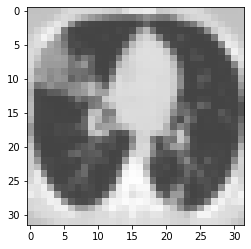

In [ ]:
plt.imshow(I1)

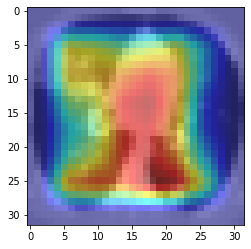

In [ ]:
plt.imshow(e_visualization)

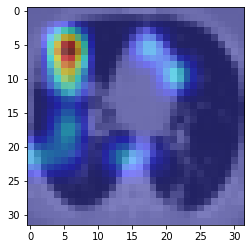

In [ ]:
plt.imshow(g_visualization)